# Plots the Sea Surface Temperature (SST) anomaly map for the preceding month, calculated from the daily mean

### Using the Climate Data Operators to calculate the daily anomalies 

0) concatenate the whole period 

`ncrcat $(/bin/ls -v  sst.day.mean.????.v2.nc) sst.day.mean.1981.2019.v2.nc`

1) concatenate the 1981 - 2010 period:  

`ncrcat $(cat lfiles) sst.day.mean.1981.2010.v2.nc`

2) calculate the daily climatology:  

`cdo ydaymean sst.day.mean.1981.2010.v2.nc sst.day.mean.1981.2010.climatology.v2.nc`

3) calculate the anomalies:  

`cdo ydaysub sst.day.mean.1981.2019.v2.nc sst.day.mean.1981.2010.climatology.v2.nc sst.day.anoms.1981.2017.v2.nc`


In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [115]:
import os, sys
import pathlib
from subprocess import call
import numpy as np
from numpy import ma
from datetime import datetime
# from mpl_toolkits.basemap import Basemap
from matplotlib import cm

import pandas as pd
import xarray as xr
import salem

In [3]:
from datetime import datetime
from dateutil.parser import parse as dparse
import calendar

In [4]:
import fiona
import geopandas 

In [5]:
import cmocean

In [6]:
from matplotlib import style

In [7]:
import seaborn as sns
sns.set_context('talk')

In [8]:
def format_vals(x):
    return "{:+4.2f}\n".format(x)

In [9]:
def make_vals(df): 
    vals = df.iloc[-1,:].to_frame()
    vals.columns = ['vals']
    vals = vals.sort_values(by='vals', ascending=False)
    valsf = list(map(format_vals, vals.values.flatten()))
    valsf = "".join(valsf)
    return valsf

### set the end date here 

In [10]:
end_date = datetime.utcnow()

### working directory 

In [11]:
wdir = '/home/nicolasf/operational/NCC/OISST_SST/notebooks/'

### set up directories paths

In [12]:
vpath = os.environ['HOME']

In [13]:
# data 
dpath = os.path.join(vpath, 'data/SST/NOAA_hires_1981_present/NZ')

# figures
fpath = os.path.join(os.environ['HOME'], 'operational/ICU/supplement/SST/figures/')

### set the domain boundaries 

In [14]:
ll_lon = 160
ur_lon = 180

ll_lat = -50
ur_lat = -30

In [15]:
dpath_download = '/home/nicolasf/data/SST/NOAA_hires_1981_present'
today = datetime.utcnow() 
today = end_date

dtdown = today

fname = "sst.day.mean.{}.v2.nc".format(dtdown.strftime("%Y"))


In [16]:
fname

'sst.day.mean.2019.v2.nc'

### download manually from [ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/](ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/)

In [17]:
download = True

In [18]:
if download: 
    print("trying to download {}".format(fname))
    cmd = "curl --silent ftp://ftp.cdc.noaa.gov/Datasets/noaa.oisst.v2.highres/{} -o {}".format(fname, os.path.join(dpath_download,fname))
    rcode = call(cmd,shell=True)
    if rcode != 0: 
        print("something went wrong with the download of {}".format(fname))

trying to download sst.day.mean.2019.v2.nc


### extraction

In [19]:
ncks = '/home/nicolasf/anaconda3/envs/NCO/bin/ncks'

In [20]:
cmd = '{0} -FOa -d lat,{1}.,{2}. -d lon,{3}.,{4}. {5}/{6} {5}/NZ/{6}'.format(ncks, ll_lat, ur_lat, ll_lon, ur_lon, dpath_download, fname)
rcode = call(cmd,shell=True)
if rcode != 0: 
    print("something went wrong the domain extraction of {}".format(fname))   

In [21]:
cmd

'/home/nicolasf/anaconda3/envs/NCO/bin/ncks -FOa -d lat,-50.,-30. -d lon,160.,180. /home/nicolasf/data/SST/NOAA_hires_1981_present/sst.day.mean.2019.v2.nc /home/nicolasf/data/SST/NOAA_hires_1981_present/NZ/sst.day.mean.2019.v2.nc'

### now runs the climate data operators

In [22]:
os.chdir(dpath)

In [23]:
dpath

'/home/nicolasf/data/SST/NOAA_hires_1981_present/NZ'

In [24]:
lfiles = ['sst.day.mean.1981.2019.v2.nc', 'sst.day.anoms.1981.2019.v2.nc']

In [25]:
for f in lfiles: 
    os.remove(os.path.join(dpath, f))

In [26]:
ncrcat = '/home/nicolasf/anaconda3/envs/NCO/bin/ncrcat'

In [27]:
call("{} $(/bin/ls -v  sst.day.mean.????.v2.nc) sst.day.mean.1981.2019.v2.nc".format(ncrcat), shell=True)

0

In [28]:
cdo = "/home/nicolasf/anaconda3/envs/CDO/bin/cdo"

In [29]:
call("{} ydaysub sst.day.mean.1981.2019.v2.nc sst.day.mean.1981.2010.climatology.v2.nc sst.day.anoms.1981.2019.v2.nc".format(cdo), shell=True)

0

### opens the dataset of anomalies

In [30]:
sst_ts = salem.open_xr_dataset(os.path.join(dpath, 'sst.day.anoms.1981.2019.v2.nc'))

In [31]:
print(sst_ts.time[-1].data)

2019-03-31T00:00:00.000000000


### make plots 

In [32]:
def plot_map_salem(compos, ax, vmin, vmax, cmap): 
    smap = compos.salem.get_map(countries=False)
    smap.set_shapefile(countries=True, color='0.4', linewidth=0.5)
    smap.set_cmap(plt.cm.RdBu_r)
    smap.set_lonlat_contours(linewidths=0.1)
    xx, yy = smap.grid.transform(compos.lon.data, compos.lat.data,
                             crs=compos.salem.grid.proj)
    im = ax.pcolormesh(xx, yy, ma.masked_invalid(compos), vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(im, shrink=0.8, ax=ax)
    smap.plot(ax=ax) 

In [33]:
def plot_map_cartopy(dset, var='sst', ndays=7, cmap=cmocean.cm.balance, vmin=-2, vmax=2, step=0.1, ax=None, title=None): 
    
    import matplotlib.ticker as mticker
    import cartopy
    import cartopy.crs as ccrs
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    from cartopy import feature as cfeature 
    from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
    
    central_longitude = 180.
    
    proj = ccrs.PlateCarree(central_longitude=central_longitude)
    
    mat = dset.isel(time=slice(-ndays, None)).mean('time')
    
    lon, lat = mat.lon.data, mat.lat.data
    
    im1 = ax.contourf(lon, lat, mat['sst'], levels=np.arange(vmin, vmax + step, step), extend='both', \
               cmap=plt.get_cmap('RdBu_r'))

    im = ax.contour(lon, lat, mat['sst'], levels=np.arange(vmin, vmax + step, step*2), extend='both', \
               cmap=cmap)

    xticks = np.arange(ll_lon, ur_lon +5., 5.)

    yticks = np.arange(ll_lat, ur_lat + 5., 5.)

    gl = ax.gridlines(draw_labels=False, lw=0.5, linestyle=':', xlocs=xticks, ylocs=yticks, crs=ccrs.PlateCarree())

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())

    ax.set_yticks(yticks, crs=ccrs.PlateCarree())

    lon_formatter = LongitudeFormatter(zero_direction_label=True, dateline_direction_label=True)

    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)

    ax.yaxis.set_major_formatter(lat_formatter)

    ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor=None, facecolor='white')

    ax.coastlines(resolution='10m', zorder=10)

    cb = plt.colorbar(im1, shrink=0.7)
    cb.set_label('℃ (anomalies)')

    ax.set_extent([ll_lon, ur_lon, ll_lat, ur_lat])
    
    if title is None: 
        ax.set_title('NOAA OISST anomalies [1981-2010 clim.]\n{} days average to {:%d %b %Y}'.format(ndays, pd.to_datetime(str(dset.time[-1].data))))
    else: 
        ax.set_title(title)

In [34]:
cmap = cmocean.cm.balance

In [35]:
os.chdir(wdir)

In [36]:
from cartopy import crs as ccrs

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


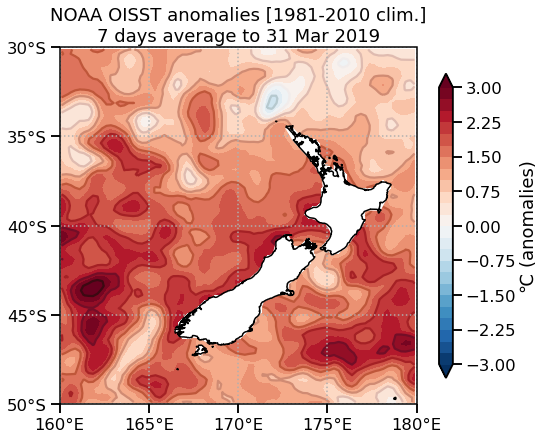

In [37]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,8))
plot_map_cartopy(sst_ts, vmin = -3, vmax=3, step=0.25, ax = ax)
f.savefig('../figures/latest_7_days_1981_2010_climo.png', dpi=300)

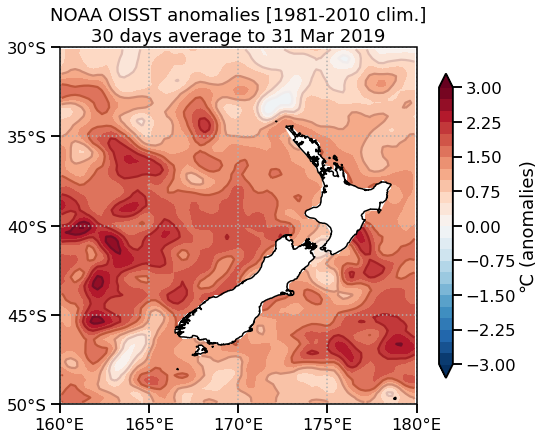

In [38]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,8))
plot_map_cartopy(sst_ts, ndays=30, ax = ax, vmin = -3, vmax=3, step=0.25)
f.savefig('../figures/latest_30_days_1981_2010_climo.png', dpi=300)

In [39]:
last_day = sst_ts.time[-1].data.astype('M8[D]').astype('O')

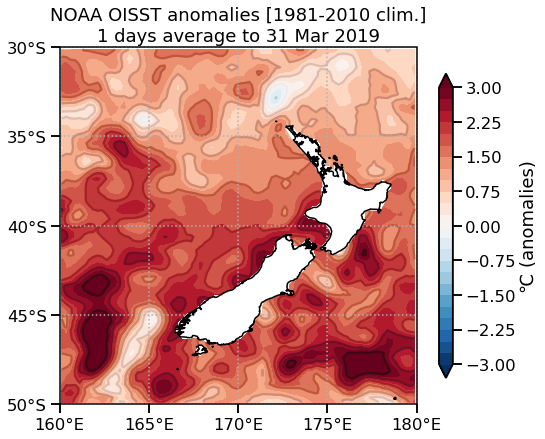

In [40]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,8))
plot_map_cartopy(sst_ts, ndays=1, ax = ax, vmin = -3, vmax=3, step=0.25)
f.savefig('../figures/latest_1_days_1981_2010_climo.png', dpi=300)

### removes the 29th of Februaries .. 

In [41]:
dates = sst_ts.time

In [42]:
dates = pd.to_datetime(dates.to_index())

In [43]:
dates = pd.DataFrame(dates, index=dates)
dates.columns = ['dates']

In [44]:
dates['dates'] = dates.dates.astype(str)

In [45]:
dates = dates[~dates.dates.str.endswith('02-29')]

In [46]:
dates.index

DatetimeIndex(['1981-09-01', '1981-09-02', '1981-09-03', '1981-09-04',
               '1981-09-05', '1981-09-06', '1981-09-07', '1981-09-08',
               '1981-09-09', '1981-09-10',
               ...
               '2019-03-22', '2019-03-23', '2019-03-24', '2019-03-25',
               '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29',
               '2019-03-30', '2019-03-31'],
              dtype='datetime64[ns]', name='time', length=13717, freq=None)

In [47]:
sst_ts = sst_ts.sel(time=dates.index)

In [48]:
sst_ts

<xarray.Dataset>
Dimensions:  (lat: 80, lon: 80, time: 13717)
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2019-03-31
  * lon      (lon) float32 160.125 160.375 160.625 ... 179.375 179.625 179.875
  * lat      (lat) float32 -49.875 -49.625 -49.375 ... -30.625 -30.375 -30.125
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    history:        Tue Apr 02 11:34:36 2019: cdo ydaysub sst.day.mean.1981.2...
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    institution:    NOAA/NCDC
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    references:     http://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    Refere

### for all regions, creates the ROI and calculates the regional average

In [49]:
# NNI = salem.read_shapefile('./NNI_buffered_2.shp')
# WNI = salem.read_shapefile('./WNI_buffered_2.shp')
# ENI = salem.read_shapefile('./ENI_buffered_2.shp')
# NSI = salem.read_shapefile('./NSI_buffered_2.shp')
# WSI = salem.read_shapefile('./WSI_buffered_2.shp')
# ESI = salem.read_shapefile('./ESI_buffered_2.shp')

In [50]:
NNI = salem.read_shapefile('./NNI_buffered_50km.shp')
WNI = salem.read_shapefile('./WNI_buffered_50km.shp')
ENI = salem.read_shapefile('./ENI_buffered_50km.shp')
NSI = salem.read_shapefile('./NSI_buffered_50km.shp')
WSI = salem.read_shapefile('./WSI_buffered_50km.shp')
ESI = salem.read_shapefile('./ESI_buffered_50km.shp')

In [51]:
ds_subset_roi_NNI = sst_ts.salem.roi(shape=NNI)
ds_subset_roi_WNI = sst_ts.salem.roi(shape=WNI)
ds_subset_roi_ENI = sst_ts.salem.roi(shape=ENI)
ds_subset_roi_NSI = sst_ts.salem.roi(shape=NSI)
ds_subset_roi_WSI = sst_ts.salem.roi(shape=WSI)
ds_subset_roi_ESI = sst_ts.salem.roi(shape=ESI)

In [52]:
def get_extreme(dset, extreme='max'):
 
    maxdf =  dset['sst'].where(dset['sst']==dset['sst'].max(), drop=True).to_dataframe()
    mindf =  dset['sst'].where(dset['sst']==dset['sst'].min(), drop=True).to_dataframe()

    extreme_df = pd.concat([maxdf, mindf], axis=1)
    
#     extreme_df.index = ['max','min']
    
    return extreme_df

In [53]:
ess = get_extreme(ds_subset_roi_NNI.sel(time=slice('2019',None)))

In [54]:
ess

,,,sst,sst
time,lat,lon,,
2019-01-15,-37.625,177.375,3.586206,NaN
2019-01-23,-38.625,174.625,NaN,-2.054827


In [55]:
ess.iloc[0,0]

3.5862064

In [56]:
get_extreme(ds_subset_roi_ENI)

,,,sst,sst
time,lat,lon,,
1983-01-28,-40.875,176.625,NaN,-3.892068
2017-12-09,-40.625,175.125,4.087666,NaN


In [57]:
# get_max(ds_subset_roi_NNI.sel(time=slice('2018',None)))

In [58]:
# get_max(ds_subset_roi_WNI.sel(time=slice('2018',None)))

In [59]:
# get_max(ds_subset_roi_NSI.sel(time=slice('2018',None)))

In [60]:
# get_max(ds_subset_roi_ESI.sel(time=slice('2018',None)))

In [61]:
# get_max(ds_subset_roi_WSI.sel(time=slice('2018',None)))

In [62]:
reg_ds_subset_roi_NNI = ds_subset_roi_NNI.mean('lon').mean('lat')
reg_ds_subset_roi_WNI = ds_subset_roi_WNI.mean('lon').mean('lat')
reg_ds_subset_roi_ENI = ds_subset_roi_ENI.mean('lon').mean('lat')
reg_ds_subset_roi_NSI = ds_subset_roi_NSI.mean('lon').mean('lat')
reg_ds_subset_roi_WSI = ds_subset_roi_WSI.mean('lon').mean('lat')
reg_ds_subset_roi_ESI = ds_subset_roi_ESI.mean('lon').mean('lat')

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [63]:
df_NNI = reg_ds_subset_roi_NNI.to_dataframe()
df_WNI = reg_ds_subset_roi_WNI.to_dataframe()
df_ENI = reg_ds_subset_roi_ENI.to_dataframe()
df_NSI = reg_ds_subset_roi_NSI.to_dataframe()
df_WSI = reg_ds_subset_roi_WSI.to_dataframe()
df_ESI = reg_ds_subset_roi_ESI.to_dataframe()

In [64]:
df = pd.concat([df_NNI, df_WNI, df_ENI, df_NSI, df_WSI, df_ESI], axis=1)

In [65]:
df.columns = ['NNI','WNI','ENI','NSI','WSI','ESI']

### daily SSTs

In [66]:
df.iloc[-1,:].to_frame()

,2019-03-31 00:00:00
NNI,1.477570
WNI,2.301576
ENI,1.715738
NSI,2.063321
WSI,2.378798
ESI,1.616367


In [67]:
valsf = make_vals(df)

In [68]:
# style.use('classic')

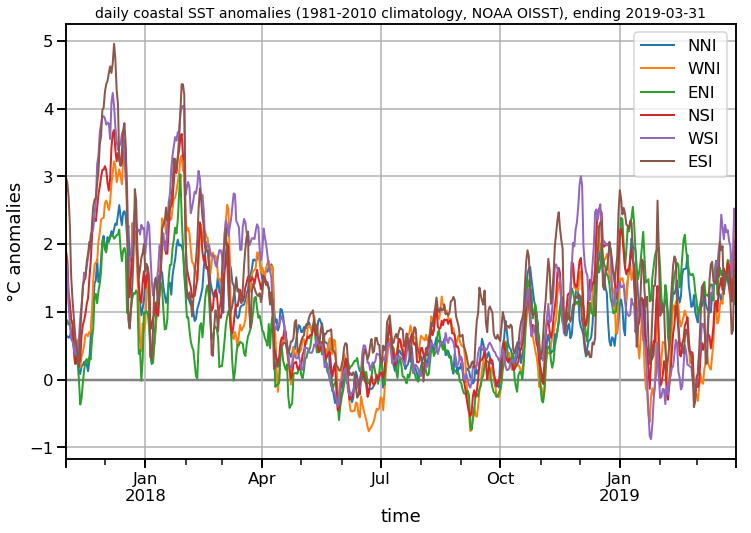

In [69]:
f, ax = plt.subplots(figsize=(12,8))

# f.subplots_adjust(right=0.8)

df.loc['2017-11':].plot(lw=2, ax=ax)

# df.loc['2017',:].rolling(window=7).mean().plot(ax=ax)

# ax.text(1.1,0.9,'NNI: 0.441509', transform=ax.transAxes )

ax.grid()

ax.axhline(0, color='k', zorder=-1)

ax.set_title('daily coastal SST anomalies (1981-2010 climatology, NOAA OISST), ending {:%Y-%m-%d}'.format(df.index[-1]), fontsize=14)

ax.set_ylabel(u"\u00b0" + "C anomalies")

# ax.text(1.01, 0.76, valsf, transform=ax.transAxes, fontsize=13)

f.savefig('../figures/daily_SST_index_{:%Y-%m-%d}_1981_2010_climo_50km.png'.format(df.index[-1]), dpi=200)

In [70]:
df.to_csv('../outputs/daily_SST_index_{:%Y-%m-%d}_1981_2010_climo_50km.csv'.format(df.index[-1]))

In [71]:
dfm = df.resample('1M').mean()

### Monthly SSTs

In [72]:
# dfm = dfm.iloc[:-1,:]

In [73]:
dfm.tail()

,NNI,WNI,ENI,NSI,WSI,ESI
time,,,,,,
2018-11-30,0.686753,0.853733,0.656216,1.023407,1.224870,1.318066
2018-12-31,0.961078,1.414545,1.268128,1.685445,1.900990,1.307577
2019-01-31,1.094665,0.774106,1.873415,1.154137,0.609470,1.627784
2019-02-28,1.241558,0.577098,1.438896,0.374182,0.070684,0.706384
2019-03-31,1.259900,0.851192,1.391415,0.996572,1.443065,1.223436


In [74]:
valsf = make_vals(dfm)

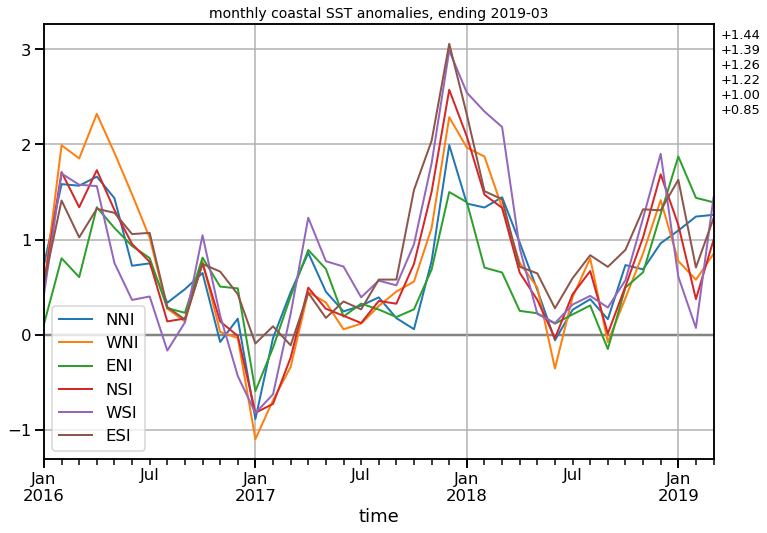

In [75]:
f, ax = plt.subplots(figsize=(12,8))

dfplot = dfm.loc['2016':None]

dfplot.plot(lw=2, ax=ax)

ax.grid()

ax.axhline(0, color='k', zorder=-1)

ax.set_title('monthly coastal SST anomalies, ending {:%Y-%m}'.format(dfplot.index[-1]), fontsize=14)

ax.text(1.01, 0.76, valsf, transform=ax.transAxes, fontsize=13)

f.savefig('../figures/monthly_SST_index_{:%Y-%m}_1981_2010_climo_50km.png'.format(dfplot.index[-1]), dpi=200)

In [76]:
dfm.to_csv('../outputs/monthly_SST_index_{:%Y-%m}_1981_2010_climo_50km.csv'.format(dfm.index[-1]))

In [77]:
dfs = dfm.rolling(window=3, min_periods=3).mean()

### Seasonal SSTs 

In [78]:
valsf = make_vals(dfs)

In [79]:
dfs.iloc[-1,]

NNI    1.198707
WNI    0.734132
ENI    1.567909
NSI    0.841630
WSI    0.707740
ESI    1.185868
Name: 2019-03-31 00:00:00, dtype: float64

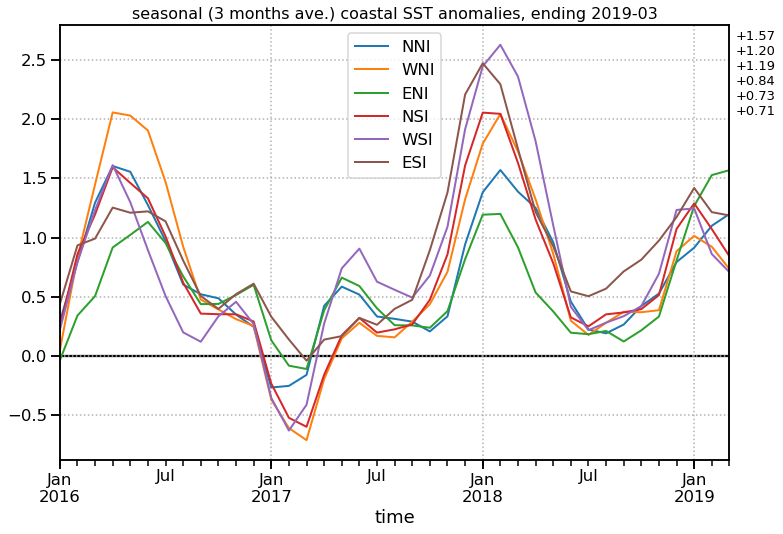

In [80]:
f, ax = plt.subplots(figsize=(12,8))

dfplot = dfs.loc['2016':None]

dfplot.plot(lw=2, ax=ax)

ax.grid(ls=':')

ax.axhline(0, color='k', zorder=-1)
ax.set_title('seasonal (3 months ave.) coastal SST anomalies, ending {:%Y-%m}'.format(dfplot.index[-1]), fontsize=16)

ax.text(1.01, 0.76, valsf, transform=ax.transAxes, fontsize=13)


f.savefig('../figures/seasonal_SST_index_{:%Y-%m}_1981_2010_climo_50km.png'.format(dfplot.index[-1]), dpi=200)

In [81]:
dfs.to_csv('../outputs/seasonal_SST_index_{:%Y-%m}_1981_2010_climo50km.csv'.format(dfs.index[-1]))

## some correlation plots 

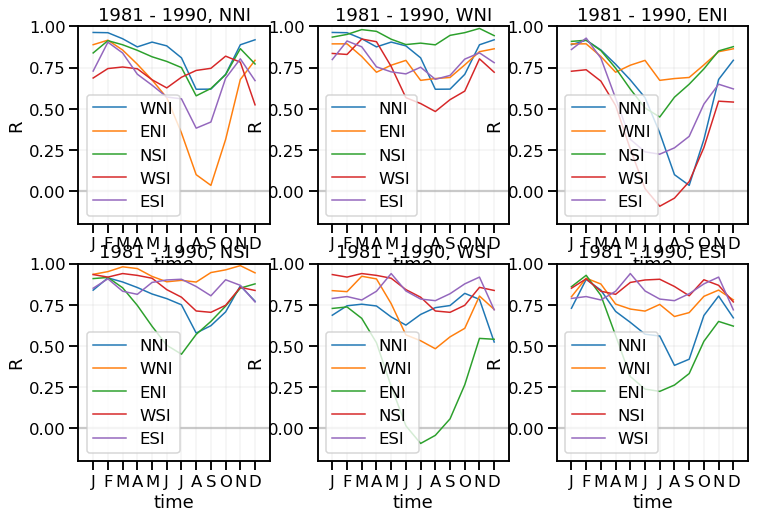

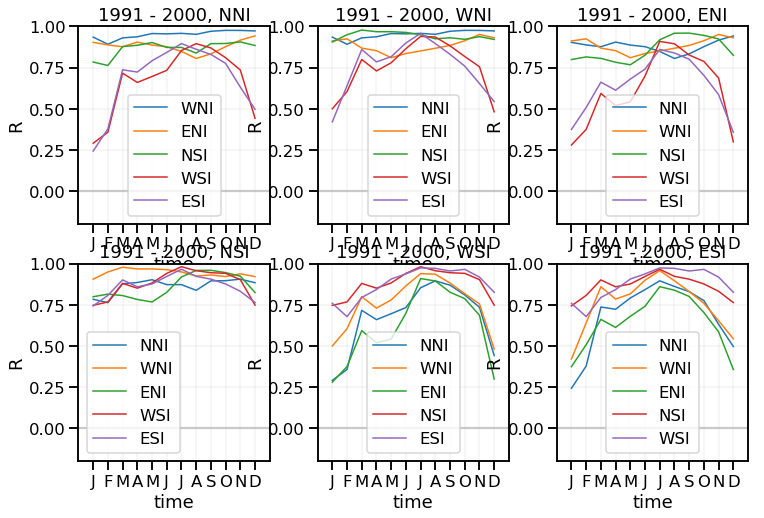

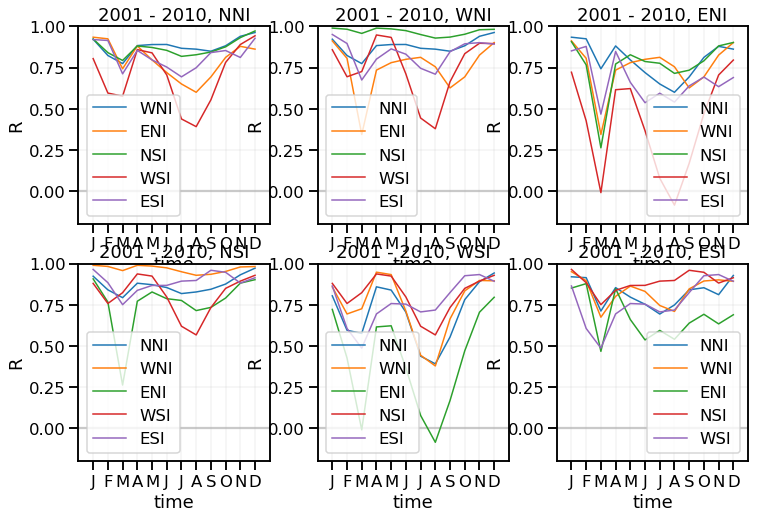

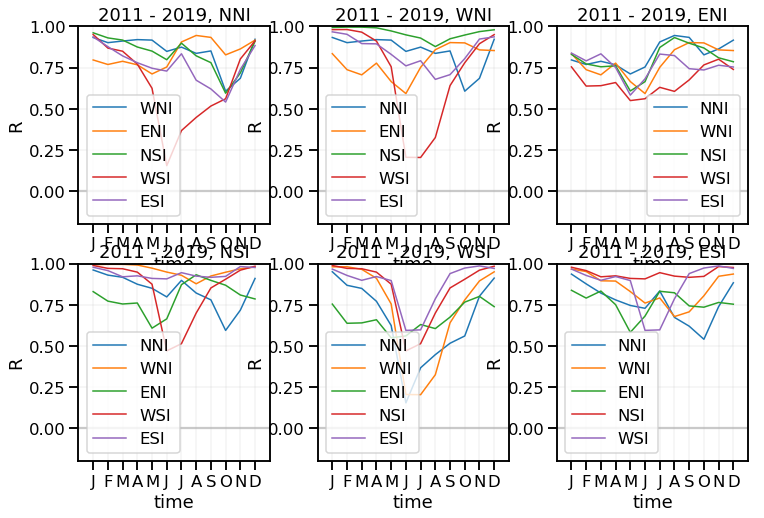

In [82]:
for y in [1981,1991,2001,2011]: 
    df_corr = dfs.loc[str(y):str(y+9)]
    corr = df_corr.groupby(df_corr.index.month).corr()
    f, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
    f.subplots_adjust(wspace=0.25)
    axes = axes.flatten() 
    for i, region in enumerate(['NNI','WNI','ENI','NSI','WSI','ESI']): 
        ax = axes[i]
        corr.loc[:,region].unstack().drop(region, axis=1).plot(ax=ax, lw=1.5)
        ax.set_xticks(range(1,13))
        ax.set_xlim(0, 13)
        ax.set_ylim(-0.2, 1)
        ax.set_xticklabels(list('JFMAMJJASOND'))
        ax.set_title("{:%Y} - {:%Y}, {}".format(df_corr.index[0], df_corr.index[-1], region))
        ax.grid(lw=0.2)
        ax.set_ylabel('R')
        ax.axhline(0, zorder=-1, color='0.8')
    f.savefig('../figures/corr_seasonal_coastal_SST_{:%Y}_{:%Y}.png'.format(df_corr.index[0], df_corr.index[-1]), dpi=300)    

In [83]:
lseas = ["".join(list('NDJFMAMJJASOND')[i:i+3]) for i in range(12)]

In [84]:
d = dict(zip(range(1,13),lseas))

In [85]:
d

{1: 'NDJ',
 2: 'DJF',
 3: 'JFM',
 4: 'FMA',
 5: 'MAM',
 6: 'AMJ',
 7: 'MJJ',
 8: 'JJA',
 9: 'JAS',
 10: 'ASO',
 11: 'SON',
 12: 'OND'}

In [86]:
# f, axes = plt.subplots(nrows=3, ncols=4, figsize=(12,8))
# axes = axes.flatten()
# for i, m in enumerate(range(1, 13)): 
#     ax = axes[i]
#     dfs.iloc[dfs.index.month == m,:].plot(ax=ax)

In [87]:
dfs.loc[:,'season'] = dfs.index.month

In [88]:
dfs = dfs.replace({'season':d})

In [89]:
dfs.tail()

,NNI,WNI,ENI,NSI,WSI,ESI,season
time,,,,,,,
2018-11-30,0.526949,0.386767,0.333379,0.514251,0.694130,0.974216,SON
2018-12-31,0.793101,0.884368,0.806515,1.072479,1.232803,1.172338,OND
2019-01-31,0.914165,1.014128,1.265919,1.287663,1.245110,1.417809,NDJ
2019-02-28,1.099100,0.921916,1.526813,1.071254,0.860381,1.213915,DJF
2019-03-31,1.198707,0.734132,1.567909,0.841630,0.707740,1.185868,JFM


In [90]:
for m in range(1,13): 
    
    dfss = dfs.iloc[dfs.index.month == m,:]
    
#     dfss = dfss.loc[None:'{:%Y-%m}'.format(end_date),:]
    
    f, ax = plt.subplots(figsize=(12,8))

    dfss.plot(lw=2, ax=ax)

    ax.grid()

    ax.axhline(0, color='k', zorder=-1)
    
    ax.set_title('{} coastal SST anomalies, ending {:%Y-%m}'.format(d[m], dfss.index[-1]), fontsize=14)

    f.savefig('../figures/{}_seasonal_SST_index_{:%Y-%m}_1981_2010_climo.png'.format(d[m], dfss.index[-1]), dpi=200)
    
    plt.close(f)

In [91]:
from pandas import ExcelWriter

In [92]:
writer = ExcelWriter('../outputs/seasonal_SST_R_{:%Y-%m}_1981_2010_climo.xlsx'.format(dfss.index[-1]))

In [93]:
for season in lseas: 
    table = dfs.query("season == '{}'".format(season)).drop('season', axis=1)
    table.to_excel(writer, season)

In [94]:
writer.save()

In [95]:
ds_subset_roi_NNI = ds_subset_roi_NNI.sel(lon=slice(163,None))
ds_subset_roi_WNI = ds_subset_roi_WNI.sel(lon=slice(163,None))
ds_subset_roi_ENI = ds_subset_roi_ENI.sel(lon=slice(163,None))
ds_subset_roi_NSI = ds_subset_roi_NSI.sel(lon=slice(163,None))
ds_subset_roi_WSI = ds_subset_roi_WSI.sel(lon=slice(163,None))
ds_subset_roi_ESI = ds_subset_roi_ESI.sel(lon=slice(163,None))

In [96]:
dset_all = xr.concat([ds_subset_roi_NNI, ds_subset_roi_WNI, ds_subset_roi_ENI, ds_subset_roi_NSI, ds_subset_roi_WSI, ds_subset_roi_ESI], dim='region')

In [97]:
dset_all['region'] = (('region'), ['NNI','WNI','ENI','NSI','WSI','ESI'])

In [98]:
# m = Basemap(projection='cyl', llcrnrlon=ds_subset_roi_NNI.lon.min(), \
#             urcrnrlon=ds_subset_roi_NNI.lon.max(), \
#             llcrnrlat=ds_subset_roi_NNI.lat.min(), \
#             urcrnrlat=ds_subset_roi_NNI.lat.max(), resolution='f', area_thresh=1000)

In [99]:
# f, axes = plt.subplots(ncols=3, nrows=2, figsize=(14, 8),subplot_kw={'projection':ccrs.PlateCarree()})
# plt.subplots_adjust(wspace=0.1)
# axes = axes.flatten()
# for i, region in enumerate(['NNI','WNI','ENI','NSI','WSI','ESI']): 
#     dset = dset_all.sel(region=region)
#     plot_map_cartopy(dset, title=region, ax=axes[i])

In [100]:
# f.savefig('../figures/last_7_days_maps_coastal_SST_1981_2010_climo.png', dpi=300)

In [101]:
dfs.corr()

,NNI,WNI,ENI,NSI,WSI,ESI
NNI,1.000000,0.910865,0.777976,0.855574,0.737313,0.739451
WNI,0.910865,1.000000,0.792698,0.953487,0.804926,0.804582
ENI,0.777976,0.792698,1.000000,0.793683,0.563530,0.670951
NSI,0.855574,0.953487,0.793683,1.000000,0.889257,0.882410
WSI,0.737313,0.804926,0.563530,0.889257,1.000000,0.845880
ESI,0.739451,0.804582,0.670951,0.882410,0.845880,1.000000


### set the month and year to calculate the CALENDAR month mean and plot for 

In [102]:
month = 3 
year= 2019

In [103]:
from calendar import monthrange

In [104]:
date_start = datetime(year, month, 1)

In [105]:
ndays = monthrange(year, month)[-1]

In [106]:
date_end = datetime(year, month, ndays)

/home/nicolasf/anaconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


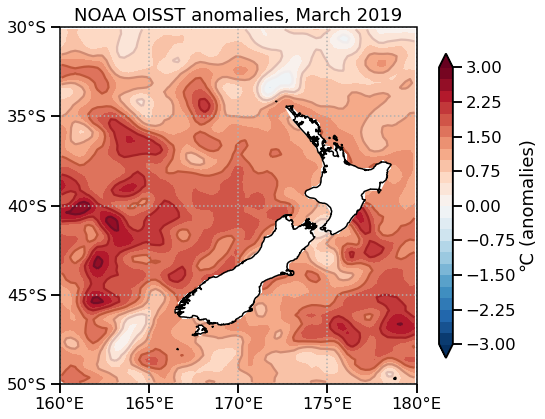

In [108]:
f, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(8,8))
plot_map_cartopy(sst_ts.sel(time=slice(date_start,date_end)), ndays=ndays, vmin = -3, vmax=3, step=0.25, ax = ax, title = 'NOAA OISST anomalies, {:%B %Y}'.format(date_end))
f.savefig('../figures/SST_anoms_{:%b_%Y}'.format(date_end))

In [109]:
from glob import glob
from shutil import copyfile

In [110]:
lfiles = glob('../figures/*.png')

In [111]:
lfiles.sort(key=lambda x: os.stat(os.path.join('../figures', x)).st_mtime)

In [112]:
lfiles = lfiles[-24:]

In [114]:
for f in lfiles: 
    fout = f.split('/')[-1]
    copyfile(f, os.path.join('/home/nicolasf/drives/well_scratch/ncc/SSTs/', fout))